In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import optimize
from scipy.stats import poisson
import math

In [2]:
#import data from excel
data = pd.read_excel('/Users/ibhallaladd/Desktop/sup_junc_data.xlsx', dtype={'Name': str, 'Value': float}, keep_default_na = False)
#rC':\Users\clair\OneDrive\Desktop\Schewl\Yale Stuff\Junior Year\AdvancedLab\'

In [3]:
data

,NIN_1_1_inc_I,NIN_1_1_inc_V,NIN_1_1_inc_V_err,NIN_1_1_dec_I,NIN_1_1_dec_V,NIN_1_1_dec_V_err,SIN_1_1_inc_I,SIN_1_1_inc_V,SIN_1_1_inc_V_err,SIN_1_1_dec_I,SIN_1_1_dec_V,SIN_1_1_dec_V_err,SIS_1_1_inc_I,SIS_1_1_inc_V,SIS_1_1_inc_V_err,SIS_1_1_dec_I,SIS_1_1_dec_V,SIS_1_1_dec_V_err
0,-0.0005,-0.0073252,1.5418e-05,-0.0005,-0.0073274,2.7669e-05,-0.0005,-0.0090332,0,-0.0005,-0.0090315,2.0365e-05,-0.000020,-0.001388,0.000003,-0.000020,-0.001396,0.000003
1,-0.00049,-0.0073076,6.1492e-05,-0.00049,-0.0073242,0,-0.00049,-0.008792,2.6597e-05,-0.00049,-0.0087898,1.3359e-05,-0.000020,-0.001387,0.000003,-0.000020,-0.001395,0.000003
2,-0.00048,-0.0070801,0,-0.00048,-0.0070854,3.5829e-05,-0.00048,-0.0087288,0.00010534,-0.00048,-0.0086831,0.00012106,-0.000020,-0.001387,0.000002,-0.000020,-0.001394,0.000004
3,-0.00047,-0.0070271,0.00010069,-0.00047,-0.0070586,6.9198e-05,-0.00047,-0.0085449,0,-0.00047,-0.0085449,0,-0.000020,-0.001386,0.000002,-0.000020,-0.001393,0.000005
4,-0.00046,-0.0068359,0,-0.00046,-0.0068379,2.176e-05,-0.00046,-0.0083064,3.6616e-05,-0.00046,-0.008304,2.7669e-05,-0.000020,-0.001386,0.000003,-0.000020,-0.001391,0.000005
5,-0.00045,-0.0067861,9.843e-05,-0.00045,-0.0068357,7.7204e-06,-0.00045,-0.0082878,5.4723e-05,-0.00045,-0.0082798,6.8483e-05,-0.000019,-0.001385,0.000004,-0.000019,-0.001390,0.000005
6,-0.00044,-0.0065918,0,-0.00044,-0.0065928,1.5418e-05,-0.00044,-0.0080566,0,-0.00044,-0.0080566,0,-0.000019,-0.001383,0.000005,-0.000019,-0.001389,0.000004
7,-0.00043,-0.0065056,0.00011673,-0.00043,-0.0065439,9.6965e-05,-0.00043,-0.0079104,0.00011971,-0.00043,-0.0078511,8.9093e-05,-0.000019,-0.001382,0.000005,-0.000019,-0.001389,0.000004
8,-0.00042,-0.0063479,7.7204e-06,-0.00042,-0.0063477,0,-0.00042,-0.0078108,2.0365e-05,-0.00042,-0.0078062,3.8871e-05,-0.000019,-0.001381,0.000005,-0.000019,-0.001388,0.000003
9,-0.00041,-0.0063459,2.0365e-05,-0.00041,-0.0063406,4.0989e-05,-0.00041,-0.0075684,0,-0.00041,-0.0075684,0,-0.000019,-0.001380,0.000004,-0.000019,-0.001388,0.000003


In [4]:

#guesses for the fit parameters
R     = 0
delta = 0
T     = 0

firstGuess = [R, delta, T]

NIN_Vinc = data['NIN_1_1_inc_V'][0:100]
NIN_Iinc = data['NIN_1_1_inc_I'][0:100]
NIN_Vinc_err = data['NIN_1_1_inc_V_err'][0:100]

SIN_Vinc = data['SIN_1_1_inc_V'][0:100]
SIN_Iinc = data['SIN_1_1_inc_I'][0:100]
SIN_Vinc_err = data['SIN_1_1_inc_V_err'][0:100]

SIN_Vdec = data['SIN_1_1_dec_V'][0:100]
SIN_Idec = data['SIN_1_1_dec_I'][0:100]
SIN_Vdec_err = data['SIN_1_1_dec_V_err'][0:100]

In [5]:
def NINcurr(v, params=[]):
    r_0 = params[0]
    b   = params[1]
    
    i   = np.zeros(len(v))
    
    for j in range(len(v)):
        i[j] = v[j]*r_0 + b
   
    return i

In [6]:
def SIScurr(v, params=[]):
    # energy and temperature measured in voltage units
    #    1 meV = 1 mV
    #    1 K   = 0.0861 mV
    # Setting parameters
    r_0      = 999
    delta_pb = 999
    delta_al = 999
    t        =  .1 #temperature
    e_max    = 999 #cutoff for approximating integral
    
    e_step   = 999 #step size for approximating integral
    r_par    = 999 #resistance parallel to junction
    e        = np.arange(-e_max, e_max, e_step)
    nptse    = len(e)
    #Import voltage data
    #Rather than taking this vector of uniformly spaced fake voltages,
    #you should import a vector containing your real voltage data.
    nptsv = len(v)
    ds_pb = np.zeros(nptse)
    ds_al = np.zeros(nptse)
    di = np.zeros(nptse)
    itot = np.zeros(nptsv)
    # step over voltage
    # for k=1:nptsv
    #at what point are things being set to 0? -- stop the integral at that time to save time
    for k in range(nptsv):
        vv = v[k]
        # do the integral over e
        for j in range(nptse):
            if np.absolute(e[j]+vv) > delta_pb:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_pb[j] = np.absolute(e[j])/np.sqrt((e[j]+vv)**2-.99*delta_pb**2)
            else:
                ds_pb[j] = 0
            if np.absolute(e[j]) > delta_al:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_al[j] = np.absolute(e[j]+vv)/np.sqrt((e[j])**2-.99*delta_al**2)
            else:
                ds_al[j] = 0            
            di[j] = ds_pb[j]*ds_al[j]*(1/(np.exp(e[j]/t)+1)-1/(np.exp((e[j]+vv)/t)+1))
        # integrate with trapezoid rule include a parallel resistance r_par
        #itot[k] = np.trapz(di,e)/r_0 + vv/r_par
        itot[k] = np.trapz(di,e)/r_0 
    return itot

In [7]:
def SINcurr(v, params=[]):
    # energy and temperature measured in voltage units
    #    1 meV = 1 mV
    #    1 K   = 0.0861 mV
    # Setting parameters
    
    r_0    = params[0]
    delta  = params[1]
    t      = params[2] 
    
    e_max  = 5 #cutoff for approximating integral
    e_step = 0.01 #step size for approximating integral
    #r_par  = 99999 #resistance parallel to junction
    
    e = np.arange(-e_max, e_max, e_step)
    nptse = len(e)
    
    #Import voltage data
    #Rather than taking this vector of uniformly spaced fake voltages,
    #you should import a vector containing your real voltage data.
    nptsv = len(v)
    ds_pb = np.zeros(nptse)
    di = np.zeros(nptse)
    itot = np.zeros(nptsv)
    
    # step over voltage
    # for k=1:nptsv
    for k in range(nptsv):
        vv = v[k]
        
        # do the integral over e
        for j in range(nptse):
            if np.absolute(e[j]) > delta:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_pb[j] = np.absolute(e[j])/np.sqrt((e[j])**2-.99*delta**2)
                
            else:
                ds_pb[j] = 0
                
            di[j] = ds_pb[j]*(1/(np.exp(e[j]/t)+1)-1/(np.exp((e[j]+vv)/t)+1))
            
        # integrate with trapezoid rule include a parallel resistance r_par
        #itot[k] = np.trapz(di,e)/r_0 + vv/r_par
        itot[k] = np.trapz(di,e)/r_0 
        
    return itot

In [11]:
#main method -- minimizing chi squared
def herbertSIN(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r        = firstGuess[0]
    r_sig    = firstGuess[1]
    delt     = firstGuess[2]
    delt_sig = firstGuess[3]
    t        = firstGuess[4]
    t_sig    = firstGuess[5]
    
    #range over which to evaluate 
    #R range is small
    #R_range   = np.arange(10, 20, 1)
    #del_range = np.arange(0.002, 0.003, 0.0001)
    #T_range   = np.arange(3.5, 4.5, 0.1)
    
    #[0.079, 0.001, 
    #0.00259, 0.0005, 
    #4.2, 2.0]
    
    R_range = np.arange(r - r_sig, r + r_sig, (2 * r_sig)/10)
    del_range = np.arange(delt - delt_sig, delt + delt_sig, (2 * delt_sig)/10) 
    #will need to go over a larger range, 0.0005-0.003 (the full value)
    T_range = np.arange(t - t_sig, t + t_sig, (2 * t_sig)/10)

    
    #final optimized values of fit parameters
    optim_R   = 0
    optim_del = 0
    optim_T   = 0
    
    #default maximum value
    scoreboard = 1000000000000000000000000
    
    for i in range(len(R_range)):
        for j in range(len(del_range)):
            for k in range(len(T_range)):

                #calculate reduced chi squared
                sum_lsq = 0
                
                for m in range(len(v)):
                    lsq = ((SINcurr(v, [R_range[i], del_range[j], T_range[k]])[m]-current[m])**2)/(current_err[m]**2)
                    sum_lsq += lsq
                    
                chi_sq = lsq / (len(v)-3)
                print('bitch: ' + str(chi_sq))
                if(chi_sq < scoreboard):
                    print("surpassed scoreboard")
                    scoreboard = chi_sq
                    optim_R    = R_range[i]
                    optim_del  = del_range[j]
                    optim_T    = T_range[k]
                        
    print("R: " + str(optim_R) + "\ndelta: " + str(optim_del) + "\nT: " + str(optim_T))   
    return optim_R, optim_del, optim_T

In [9]:
#main method -- minimizing chi squared
def herbertSIN_debug(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r        = firstGuess[0]
    #r_sig    = firstGuess[1]
    delt     = firstGuess[1]
    delt_sig = firstGuess[2]
    t        = firstGuess[3]
    t_sig    = firstGuess[4]
    
    #range over which to evaluate 
    #R range is small
    #R_range   = np.arange(10, 20, 1)
    #del_range = np.arange(0.002, 0.003, 0.0001)
    #T_range   = np.arange(3.5, 4.5, 0.1)
    
    #[0.079, 0.001, 
    #0.00259, 0.0005, 
    #4.2, 2.0]
    
    #R_range = np.arange(r - r_sig, r + r_sig, (2 * r_sig)/2)
    del_range = np.arange(delt - delt_sig, delt + delt_sig, (2 * delt_sig)/2)
    T_range = np.arange(t - t_sig, t + t_sig, (2 * t_sig)/2)

    
    #final optimized values of fit parameters
    #optim_R   = 0
    optim_del = 0
    optim_T   = 0
    
    #default maximum value
    scoreboard = 1000000000000000000000000
    
    for j in range(len(del_range)):
        for k in range(len(T_range)):
            print('bitch')

            #calculate reduced chi squared
            sum_lsq = 0

            for m in range(len(v)):
                lsq = ((SINcurr(v, [r, del_range[j], T_range[k]])[m]-current[m])**2)/(current_err[m]**2)
                sum_lsq += lsq

            chi_sq = lsq / (len(v)-3)
            if(chi_sq < scoreboard):
                print("surpassed scoreboard")
                scoreboard = chi_sq
                #optim_R    = R_range[i]
                optim_del  = del_range[j]
                optim_T    = T_range[k]
                        
    print("R: " + str(r) + "\ndelta: " + str(optim_del) + "\nT: " + str(optim_T))   
    return optim_del, optim_T

In [10]:
#main method -- minimizing chi squared
def herbertNIN(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r_0   = firstGuess[0]
    r_sig = firstGuess[1]
    b_0   = firstGuess[2]
    b_sig = firstGuess[3]
    
    #range over which to evaluate 
    #R range is small
    R_range = np.arange(r_0 - r_sig, r_0 + r_sig, (2 * r_sig)/10)
    b_range = np.arange(b_0 - b_sig, b_0 + b_sig, (2 * b_sig)/10)
    
    #final optimized values of fit parameters
    optim_R = 0
    optim_b = 0
    lsq     = 0
    #default maximum value
    scoreboard = 1000000000000000000000000
    
    for j in range(len(R_range)):
        for k in range(len(b_range)):
            #calculate reduced chi squared
            sum_lsq = 0

            for m in range(len(v)):
                if current_err[m] == 0:
                    current_err[m] = (NINcurr(v, [ R_range[j], b_range[k] ]))[m]/10
                    
                lsq = ((NINcurr(v, [ R_range[j], b_range[k] ])[m] - current[m])**2)/(current_err[m]**2)
                sum_lsq += lsq

            print("lsq = " + str(lsq))    
            chi_sq = lsq / (len(v)-2)
            print("chisq = " + str(chi_sq))
            if(chi_sq < scoreboard):
                print("surpassed scoreboard")
                scoreboard = chi_sq
                optim_R    = R_range[j]
                optim_b    = b_range[k]
                        
    print("R: " + str(optim_R) + "\nb: " + str(optim_b))   
    return optim_R, optim_b

(-0.01, 0.01)

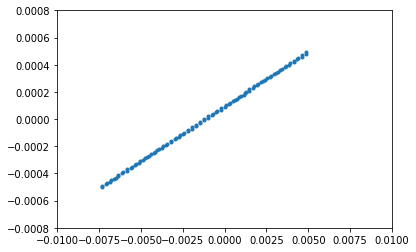

In [10]:
plt.scatter(NIN_Vinc, NIN_Iinc, marker='.')
#from NIN b offset, m=12.46 Ohms, b= -0.0012 V
#for SIN data, T is fixed at 4.2K
#delta = (4.2 K)(kB)(transition temp of lead) = (4.2 K)(kB)(7.175 K) = 0.00259 eV

#plt.plot(NIN_Vinc, NINcurr(SIN_Vinc, [12.46, 0.00259, 4.2]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

In [ ]:
optim_R, optim_del, optim_T = herbertSIN(SIN_Vinc, SIN_Iinc, SIN_Vinc_err, [79.9, 10, 0.00259, 0.002, .00036204, 0.00005])
#del sigma should be 0.005
plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [optim_R, optim_del, optim_T]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

/Users/ibhallaladd/opt/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars


bitch: 0.18972933540530887
surpassed scoreboard
bitch: 0.18972901549250037
surpassed scoreboard
bitch: 0.18972858481159524
surpassed scoreboard
bitch: 0.1897280161606928
surpassed scoreboard
bitch: 0.1897272785098532
surpassed scoreboard
bitch: 0.18972633697804844
surpassed scoreboard
bitch: 0.18972515287633412
surpassed scoreboard
bitch: 0.18972368381407118
surpassed scoreboard
bitch: 0.1897218838633122
surpassed scoreboard
bitch: 0.18971970377518896
surpassed scoreboard
bitch: 0.18971709124128514
surpassed scoreboard
bitch: 0.18972933316111418
bitch: 0.18972901223927802
bitch: 0.18972858019997607
bitch: 0.18972800975551254
bitch: 0.18972726977807933
bitch: 0.1897263252766352
bitch: 0.1897251374402139
bitch: 0.1897236637444828
bitch: 0.1897218581166474
bitch: 0.18971967115252408
bitch: 0.18971705037873798
surpassed scoreboard
bitch: 0.1897293297401704
bitch: 0.18972900728022035
bitch: 0.18972857317024305
bitch: 0.18972799999176027
bitch: 0.18972725646777835
bitch: 0.18972630743955712


bitch: 0.1897252065974159
bitch: 0.18972375366063998
bitch: 0.18972197346735464
bitch: 0.18971981730922496
bitch: 0.18971723345192762
bitch: 0.1897293332553036
bitch: 0.1897290123758166
bitch: 0.18972858039352702
bitch: 0.18972801002433973
bitch: 0.18972727014455423
bitch: 0.1897263257677466
bitch: 0.189725138088072
bitch: 0.18972366458680878
bitch: 0.1897218591972419
bitch: 0.18971967252170602
bitch: 0.18971705209375003
bitch: 0.189729321523915
bitch: 0.18972899536979843
bitch: 0.18972855628657434
bitch: 0.18972797654165807
bitch: 0.18972722449974982
bitch: 0.1897262645993382
bitch: 0.18972505739671885
bitch: 0.189723559674294
bitch: 0.1897217246081727
bitch: 0.18971950198878876
bitch: 0.18971683848738324
bitch: 0.18972930778126212
bitch: 0.18972897544821818
bitch: 0.18972852804665485
bitch: 0.1897279373186084
bitch: 0.18972717102946954
bitch: 0.18972619294404608
bitch: 0.18972496287141857
bitch: 0.18972343677529832
bitch: 0.1897215669448085
bitch: 0.18971930221929142
bitch: 0.1897165

bitch: 0.1897256675454101
bitch: 0.189724352971772
bitch: 0.18972274230560146
bitch: 0.18972079147660897
bitch: 0.18971845367649245
bitch: 0.18972940380869815
bitch: 0.18972911465120804
bitch: 0.18972872537444865
bitch: 0.18972821139157656
bitch: 0.18972754465569658
bitch: 0.18972669363901476
bitch: 0.18972562337184135
bitch: 0.1897242955385774
bitch: 0.18972266862626655
bitch: 0.18972069812014186
bitch: 0.1897183367398247
bitch: 0.18972939606000536
bitch: 0.18972910341857172
bitch: 0.18972870945157583
bitch: 0.18972818927594176
bitch: 0.18972751450685613
bitch: 0.18972665323667146
bitch: 0.18972557007438157
bitch: 0.18972422624276666
bitch: 0.18972257972873904
bitch: 0.18972058548125012
bitch: 0.18971819565034068
bitch: 0.18972938684766696
bitch: 0.1897290900642102
bitch: 0.18972869052104252
bitch: 0.18972816298290038
bitch: 0.18972747866322337
bitch: 0.18972660520276094
bitch: 0.1897255067096082
bitch: 0.18972414385773062
bitch: 0.18972247403944095
bitch: 0.18972045156611292
bitch: 0

bitch: 0.18972700396537998
bitch: 0.18972603274436983
bitch: 0.18972482779295857
bitch: 0.18972335143968108
bitch: 0.18972156328894138
bitch: 0.18971942043531684
bitch: 0.18972945954290432
bitch: 0.18972919544445999
bitch: 0.1897288399032824
bitch: 0.18972837046325042
bitch: 0.18972776150802612
bitch: 0.1897269842420057
bitch: 0.18972600672592768
bitch: 0.1897247939645237
bitch: 0.18972330804217366
bitch: 0.1897215083014777
bitch: 0.18971935155895123
bitch: 0.18972945470328062
bitch: 0.18972918842885908
bitch: 0.18972882995828583
bitch: 0.18972835665042007
bitch: 0.1897277426778689
bitch: 0.18972695900778055
bitch: 0.18972597343774852
bitch: 0.18972475068418562
bitch: 0.1897232525190983
bitch: 0.18972143795013352
bitch: 0.18971926343805268
bitch: 0.18972944872965447
bitch: 0.18972917976938888
bitch: 0.1897288176830149
bitch: 0.18972833960101942
bitch: 0.1897277194355004
bitch: 0.18972692786076786
bitch: 0.18972593234961113
bitch: 0.1897246972625664
bitch: 0.18972318398607377
bitch: 0.1

bitch


/Users/ibhallaladd/opt/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


surpassed scoreboard
bitch
surpassed scoreboard
bitch
surpassed scoreboard
bitch
bitch
bitch
surpassed scoreboard
R: 79.9
delta: 0.00259
T: 0.00041204


(-0.01, 0.01)

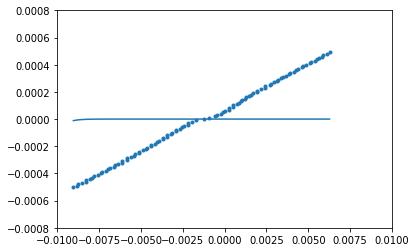

In [158]:
#this is the right order of inputs and outputs, we ARE trying to fit the squiggles 
optim_del, optim_T = herbertSIN_debug(SIN_Iinc, SIN_Vinc, SIN_Vinc_err, [79.9, 0.00259, 0.0005, .00036204, 0.00005])
#everything should be in meV (including temperature)
plt.scatter(SIN_Vinc, SIN_Iinc, marker='.')

plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [79.9, optim_del, optim_T]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

In [147]:
SINcurr(SIN_Vinc, [79.9, 2.59, .36204])

array([-6.52600015e-15, -6.35039922e-15, -6.32700628e-15, -6.17267522e-15,
       -5.99819280e-15, -5.99131697e-15, -5.81959392e-15, -5.73683348e-15,
       -5.64253539e-15, -5.46679281e-15, -5.34973810e-15, -5.29037274e-15,
       -5.11419772e-15, -5.04649886e-15, -4.93797279e-15, -4.76228680e-15,
       -4.74727602e-15, -4.58577834e-15, -4.41539378e-15, -4.40966168e-15,
       -4.23378923e-15, -4.21682625e-15, -4.05786703e-15, -3.92602231e-15,
       -3.88178526e-15, -3.70635050e-15, -3.69169349e-15, -3.53053616e-15,
       -3.39854885e-15, -3.35452608e-15, -3.17974697e-15, -3.17418836e-15,
       -3.00374786e-15, -2.93928566e-15, -2.82824780e-15, -2.65711455e-15,
       -2.65266190e-15, -2.47928818e-15, -2.47688102e-15, -2.30218127e-15,
       -2.29051863e-15, -2.12695796e-15, -2.08246249e-15, -1.95175820e-15,
       -1.85354773e-15, -1.77665476e-15, -1.60531886e-15, -1.59608623e-15,
       -1.42659111e-15, -1.24883579e-15, -9.01962230e-16, -6.82169090e-16,
       -4.45670489e-16, -

In [ ]:
plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [79.9, 0.00259, 0.00036204]))
#R = 79.9 (Ohms)
#del_Pb = 0.00259 eV
#T = 0.00036204 eV
#T = 0.36204 meV
plt.scatter(SIN_Vinc, SIN_Iinc, marker='.')
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

In [ ]:
plt.scatter(SIN_Vinc, SIN_Iinc, marker='.')
#from NIN b offset, m=12.46 Ohms, b= -0.0012 V
#for SIN data, T is fixed at 4.2K
#delta = (4.2 K)(kB)(transition temp of lead) = (4.2 K)(kB)(7.175 K) = 0.00259 eV

plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [10, .0025, 4.3999999]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

lsq = 306.40058692905683
chisq = 3.1265366013169062
surpassed scoreboard
lsq = 215.60070579507916
chisq = 2.2000072019906036
surpassed scoreboard
lsq = 140.7163881278203
chisq = 1.4358815115083703
surpassed scoreboard
lsq = 81.74763392728029
chisq = 0.834159529870207
surpassed scoreboard
lsq = 38.69444319345912
chisq = 0.3948412570761135
surpassed scoreboard
lsq = 11.556815926356796
chisq = 0.11792669312608975
surpassed scoreboard
lsq = 0.33475212597331416
chisq = 0.0034158380201358587
surpassed scoreboard
lsq = 5.028251792308688
chisq = 0.051308691758251916
lsq = 25.63731492536298
chisq = 0.2616052543404386
lsq = 62.161941525135965
chisq = 0.6343055257666935
lsq = 197.70506598934432
chisq = 2.01739863254433
lsq = 126.3333131791903
chisq = 1.2891154406039826
lsq = 70.87712383575511
chisq = 0.7232359575077052
lsq = 31.336497959038766
chisq = 0.3197601832554976
lsq = 7.711435549041277
chisq = 0.07868811784735998
lsq = 0.0019366057626300937
chisq = 1.9761283292143815e-05
surpassed scorebo

(-0.01, 0.01)

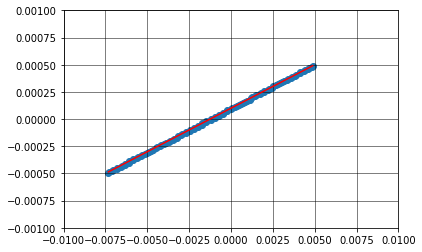

In [46]:

optim_R, optim_b = herbertNIN(NIN_Vinc, NIN_Iinc, NIN_Vinc_err, [0.12, 0.05, 0.0001, .0002])
#print("test R: " + str(optim_R) + "\nb: " + str(optim_b))   


#plt.plot(NIN_Vinc, NINcurr(NIN_Vinc, [optim_R, optim_b]))
#plt.scatter(NIN_Vinc, NIN_Iinc)

plt.scatter(NIN_Vinc, NIN_Iinc)
plt.plot(NIN_Vinc, NINcurr(NIN_Vinc, [optim_R, optim_b]), color='r', linewidth=1)
plt.grid(color='k', linestyle='-', linewidth=0.5)

plt.ylim(-0.001, 0.001)
plt.xlim(-0.01, 0.01)

(-0.01, 0.01)

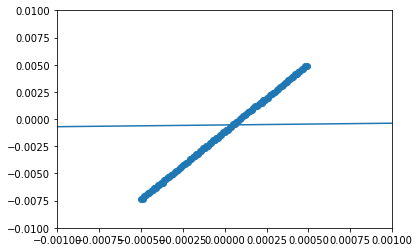

In [35]:
plt.plot(NIN_Vinc, NINcurr(NIN_Vinc, [0.07999999999999999, 0.0001]))
plt.scatter(NIN_Iinc, NIN_Vinc)

plt.xlim(-0.001, 0.001)
plt.ylim(-0.01, 0.01)

In [67]:
def red_chisq(o, c, var, m):
    #v = n - m
    v = len(o) - m
    chi = 0
    for i in range(len(o)):
        chi = chi + ( (o[i] - c[i])**2) / (var[i]**2)
        #print(o[i]-c[i])
        #print(str(beta[i])+ ": "+str((o[i]-c[i])**2/var[i]**2))
        
    return chi / v